<a href="https://colab.research.google.com/github/liamlio/StockPrediction/blob/master/Linear_Regression_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Pridicting stock price using linear regression models from the sk learn
#tool kit in order to predict the stock price of Tesla based on previous
#historical data

#Needed dependencies
import pandas as pd
import datetime 
import pandas_datareader.data as web
import math
import numpy as np

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 9, 5)

df = web.DataReader("TSLA", "yahoo", start, end)

In [43]:
df.head()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,25.00,17.540001,19.000000,23.889999,18766300,23.889999
2010-06-30,30.42,23.299999,25.790001,23.830000,17187100,23.830000
2010-07-01,25.92,20.270000,25.000000,21.959999,8218800,21.959999
2010-07-02,23.10,18.709999,23.000000,19.200001,5139800,19.200001
2010-07-06,20.00,15.830000,20.000000,16.110001,6866900,16.110001


To determine the trend of the stock, the rolling mean (moving average) can be used to remove the noise in the historical price movements.


In [0]:
close_pr = df['Adj Close']
mavg = close_pr.rolling(window=100).mean()

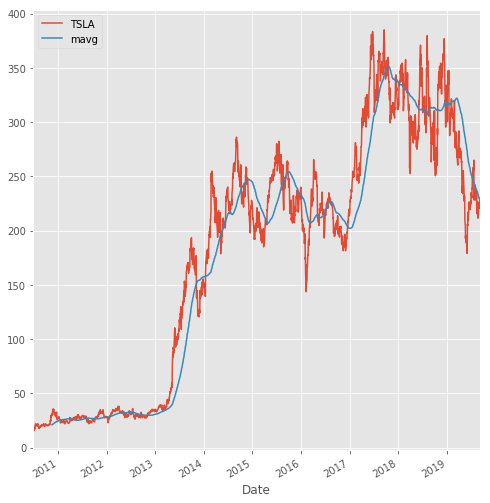

In [45]:
#A quick visualization to get a better idea of the moving average
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import style

#Adjusting the size of the plot
mpl.rc('figure', figsize=(8, 9))
mpl.__version__

#Adjusting the style of the plot
style.use('ggplot')

close_pr.plot(label='TSLA')
mavg.plot(label='mavg')
plt.legend()

**Return Deviation:** to determine risk and return

`Expected Return measures the mean, or expected value, of the probability distribution of investment returns. The expected return of a portfolio is calculated by multiplying the weight of each asset by its expected return and adding the values for each investment — Investopedia.`

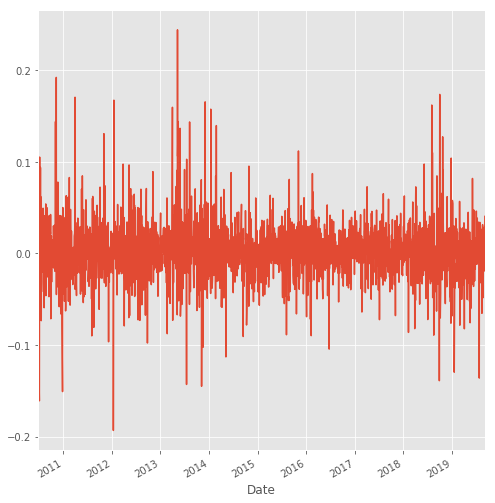

In [46]:
rets = close_pr/close_pr.shift(1) - 1  #Formula is Pt/P(t-1) - 1 where t is the subcript of P

rets.plot(label='return')

Just from the above graph you can see the volatility that incompasses Tesla Motors and the gains and loses of almost or more then 20% in a single day prior to 2015. However, the stock experienced relative stability for 3 years between 2015 and 2018 before Tesla regained much more public scrutinity at the end of 2018 and during 2019 during the SEC scandal and growing concerns of being profitable. But, the last year and half also contained many milestone and beating competitors in sales as well.

# Engineering Some New Features

High low Percentage and Percentage change


In [0]:
dfeng = df.loc[:, ['Adj Close', 'Volume']]

# H/L %

dfeng['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100

# % Change - the change between the closing and opening price of the proceding day

dfeng['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100

In [0]:
dfeng.head()

In [0]:

#Some preprocessing

#Drop missing values
dfeng.fillna(value=-9999, inplace=True)

#Forecast data, the values to be predicted

forecast_out = 100 #int(math.ceil(0.01*len(dfeng)))

#We want to predict the Adj Close
forecast_col = 'Adj Close'
#Replacing the old name
dfeng['label'] = dfeng[forecast_col].shift(-forecast_out)
X = dfeng.drop(['label'], 1)


In [0]:
#Scaling X in order for the data to have the same distribution for linear regression
#from sklearn import preprocessing
#X = preprocessing.scale(X)

#We want to forecast the future values of X, therefore
#We seperate X to early X (to train) and late X
X_forecast = X[-forecast_out:] #The most recent 100 closing prices
X = X[:-forecast_out]

#Seperate labels and identify it as y for convenience
y = np.array(dfeng['label'])
y = y[:-forecast_out]

In [0]:
X_forecast.index

### Playing around with a couple Linear models

1. Linear Regression as a benchmark
<br>
2.Use of a Robust linear model RANSAC
<br>
3.A Probabilistic Model, Bayesian Ridge Regression

In [0]:
#Importing the linear models
from sklearn.linear_model import LinearRegression, BayesianRidge, RANSACRegressor
olf = LinearRegression()
BR = BayesianRidge()
RANSAC = RANSACRegressor()


In [0]:
print(X.shape, X_forecast.shape)
len(y)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


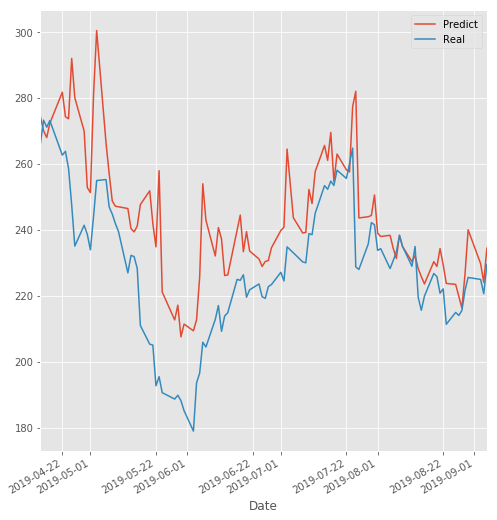

In [110]:
#Starting with Linear regression
olf.fit(X, y)

predict_olf = olf.predict(X_forecast)

#Plotting the results
dfeng['Forecast'] = np.nan
dfeng['Forecast'][-100:] = predict_olf #Just an easy way to get the proper indexes

#close_pr.plot(label='TSLA')
#mavg.plot(label='mavg')


dfeng['Forecast'][-100:].plot(label='Predict')
plt.plot(df['Adj Close'][-100:], label='Real')
plt.legend()



In [111]:
#Checking accuracies, even do it really doesn't look great from the graph above..
olf.score(X, y) #Training score accuracy

0.8458613981506186

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


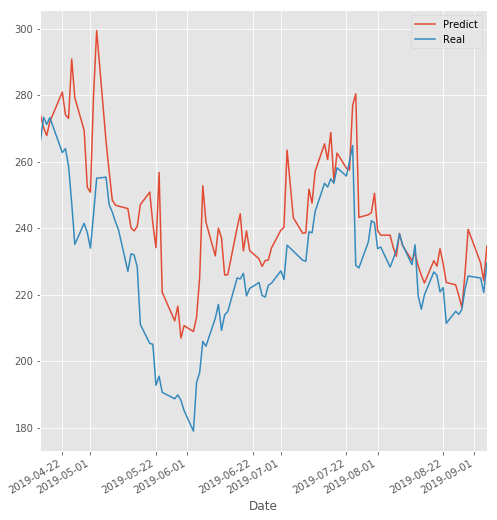

In [115]:
#The other methods
BR.fit(X, y)

predict_BR = BR.predict(X_forecast)

#Plotting the results
dfeng['Forecast'] = np.nan
dfeng['Forecast'][-100:] = predict_BR #Just an easy way to get the proper indexes

#close_pr.plot(label='TSLA')
#mavg.plot(label='mavg')


dfeng['Forecast'][-100:].plot(label='Predict')
plt.plot(df['Adj Close'][-100:], label='Real')
plt.legend()



In [113]:
BR.score(X, y) #Training score accuracy

0.8458334673067721

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


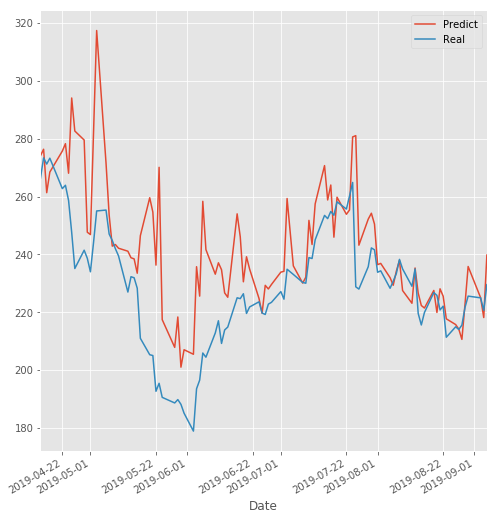

In [116]:
RANSAC.fit(X, y)

predict_RANSAC = RANSAC.predict(X_forecast)

#Plotting the results
dfeng['Forecast'] = np.nan
dfeng['Forecast'][-100:] = predict_RANSAC #Just an easy way to get the proper indexes

#close_pr.plot(label='TSLA')
#mavg.plot(label='mavg')


dfeng['Forecast'][-100:].plot(label='Predict')
plt.plot(df['Adj Close'][-100:], label='Real')
plt.legend()

In [0]:
RANSAC.score(X, y)#Training score accuracy
